In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style("whitegrid")
from scipy.io import loadmat

# Part 1.1) Loading and visualizing the data

In [3]:
# %  Our example case consists of 2 network server statistics across
# %  several machines: the latency and throughput of each machine.
# %  This exercise will help us find possibly faulty (or very fast) machines.

data_11 = loadmat('ex8data1.mat')
data_11.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [4]:
X_11, Xval_11, yval_11 = data_11['X'], data_11['Xval'], data_11['yval']

In [5]:
X_11.shape

(307, 2)

In [6]:
Xval_11.shape

(307, 2)

In [7]:
yval_11.shape

(307, 1)

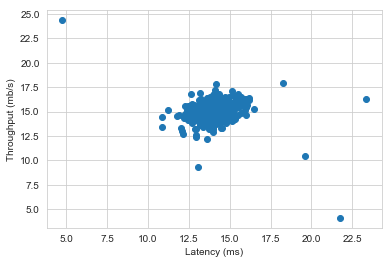

In [8]:
plt.scatter(X_11[:,0], X_11[:,1])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

# Part 1.2) Estimate the dataset statistics

In [9]:
#For this exercise we assume a Gaussian distribution for the dataset

# First estimate parameters, then compute the probability of each point and then visualize the overall distribution,
## and where each of the points falls in that distribution
def estimateGaussian(X):
    m,n = X.shape[0], X.shape[1]
    mu = np.zeros((n,1))
    sigma2 = np.zeros((n,1))
    
    mu = np.mean(X, axis = 0)
    sigma2 = np.var(X, axis = 0)
    return mu, sigma2

In [10]:
mu_11, sigma2_11 = estimateGaussian(X_11)


In [11]:
mu_11, sigma2_11

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [12]:
def multivariateGaussian(X,mu,sigma2):
    '''Computes the probability density function of the examples X under the 
       multivariate gaussian distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
       treated as the covariance matrix. If Sigma2 is a vector, it is treated
       as the \sigma^2 values of the variances in each dimension (a diagonal covariance matrix)'''
    
    k = len(mu)
    sigma2 = np.diag(sigma2)
    X = X-mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p

In [13]:
p = multivariateGaussian(X_11,mu_11,sigma2_11)

In [14]:
print(sigma2_11)
print(np.diag(sigma2_11))

[1.83263141 1.70974533]
[[1.83263141 0.        ]
 [0.         1.70974533]]


In [15]:
p.shape

(307,)

In [16]:
def visualizeFit(X,mu,sigma2):
    xx,yy = np.meshgrid(np.arange(0,35,0.5), np.arange(0,35,0.5))
    Z = multivariateGaussian(np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis])),mu,sigma2) #find probability density of the meshgrid from already fitted params
    contour_level = 10**np.array([np.arange(-20,0,3,dtype=np.float)]).T
    plt.scatter(X[:,0], X[:,1])
    plt.contour(xx,yy,Z[:,np.newaxis].reshape(xx.shape),contour_level)
    plt.xlim(0,35)
    plt.ylim(0,35)
    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")

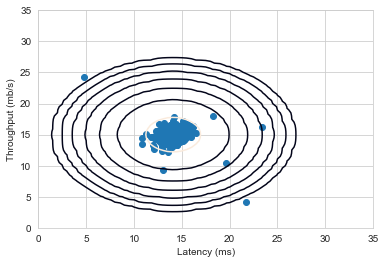

In [17]:
visualizeFit(X_11,mu_11,sigma2_11)


In [18]:
np.array([np.arange(-20,0,3,dtype=np.float)]).T

array([[-20.],
       [-17.],
       [-14.],
       [-11.],
       [ -8.],
       [ -5.],
       [ -2.]])

# Part 1.3) Find outliers
### Now you will find a good epsilon threshold using a cross-validation set probabilities given the estimated Gaussian distribution

In [19]:
p = multivariateGaussian(X_11,mu_11,sigma2_11) #finding probability of points in X dataset
min(p),max(p)

(1.1812091168967527e-23, 0.08986095083415366)

In [20]:
pval = multivariateGaussian(Xval_11,mu_11,sigma2_11) #finding probability of points in Xval dataset

In [21]:
def selectThreshold(yval, pval):
    bestEpsilon = 0.0
    bestF1 = 0.0
    F1 = 0.0
    
    stepsize = (max(pval) - min(pval))/1000
    epi_range = np.arange(min(pval),max(pval),stepsize)
    for epi in epi_range:
        predictions = (pval<epi)[:,np.newaxis] #boolean mask. True for anomalous
        tp = np.sum(predictions[yval==1]==1)
        fp = np.sum(predictions[yval==0]==1)
        fn = np.sum(predictions[yval==1]==0)
        recall = tp/(tp + fn)
        precision = tp/(tp + fp)
        F1 =(2 * precision * recall)/(precision + recall)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epi
    return bestF1, bestEpsilon
        
    

In [22]:
F1, epsilon = selectThreshold(yval_11,pval)
print("Best epsilon found using cross-validation:",epsilon)
print("Best F1 on Cross Validation Set:",F1)

Best epsilon found using cross-validation: 8.990852779269496e-05
Best F1 on Cross Validation Set: 0.8750000000000001


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


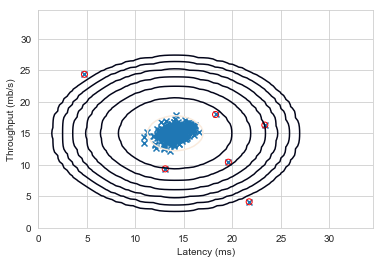

In [26]:

#Plot the data
plt.scatter(X_11[:,0],X_11[:,1],marker = 'x')
xx, yy = np.meshgrid(np.arange(0,35,0.5),np.arange(0,35,0.5))
Z = multivariateGaussian(np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis])),mu_11,sigma2_11) #height values over which contour is drawn
Z = Z[:,np.newaxis].reshape(xx.shape)
levels = 10**np.array([np.arange(-20,0,3,dtype=np.float)]).T
plt.contour(xx,yy,Z,levels)

#Let's circle the outliers
outliers = np.nonzero(p<epsilon)[0] #find indices of data points where the value is less than epsilon
plt.scatter(X_11[outliers,0],X_11[outliers,1],marker='o',edgecolor='r',facecolor = "none")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()


# Part 1.4) Multidimensional Outliers

In [27]:
data_14 = loadmat('ex8data2.mat')
data_14.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [28]:
X_14, Xval_14, yval_14 = data_14['X'], data_14['Xval'], data_14['yval']

In [29]:
X_14.shape,Xval_14.shape,yval_14.shape

((1000, 11), (100, 11), (100, 1))

In [30]:
#Fit mu and variance on the training data set
mu_14, sigma2_14 = estimateGaussian(X=X_14)

#Training set. Get probability of each point being anomalous in the training data set
p_14 = multivariateGaussian(X_14, mu_14, sigma2_14)

#Cross validation set. Get probability of each point being anomalous in the cross validation set
pval_14 = multivariateGaussian(Xval_14,mu_14,sigma2_14)

#Find the threshold
F1_14, epsilon_14 = selectThreshold(yval_14,pval_14)

print("Best epsilon found using cross-validation:",epsilon_14)
print("Best F1 on Cross Validation Set:",F1_14)
print("Outliers found : ",np.sum(p_14<epsilon_14))

Best epsilon found using cross-validation: 1.377228890761358e-18
Best F1 on Cross Validation Set: 0.6153846153846154
Outliers found :  117


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


In [31]:
mu_14,sigma2_14

(array([  4.93940034,  -9.63726819,  13.81470749, -10.4644888 ,
         -7.95622922,  10.19950372,  -6.01940755,   7.96982896,
         -6.2531819 ,   2.32451289,   8.47372252]),
 array([60.97489373, 53.20572186, 58.51546272, 84.20403725, 65.26859177,
        89.57487757, 55.63349911, 87.16233783, 29.62926829, 70.7852052 ,
        50.50356719]))

# Part 2.1) Collaborative Filtering : Loading and Visualizing Data

In [32]:
data_21 = loadmat('ex8_movies.mat')
data_21.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [33]:
Y,R = data_21['Y'], data_21['R']

In [34]:
Y.shape, R.shape
#Y is ratings (1-5) of 1682 movies on 943 users
#R[i,j] is 1 if a user j (1 to 943) has given a rating to the movie i in (1-1682)

((1682, 943), (1682, 943))

In [35]:
print("Average rating for movie 1 (Toy Story):",np.sum(Y[0,:]*R[0,:])/np.sum(R[0,:]))

Average rating for movie 1 (Toy Story): 3.8783185840707963


Text(0,0.5,'Movies')

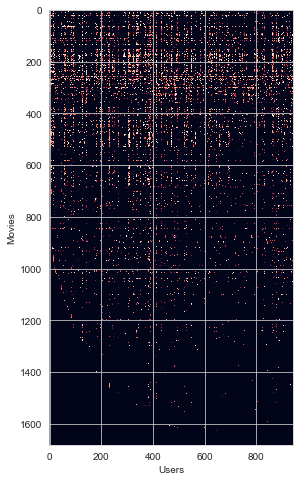

In [36]:
plt.figure(figsize=(6,8))
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Movies")

# Part 2.2, 2.3 and 2.4) Collaborative filtering cost function

In [37]:
data_22 = loadmat('ex8_movieParams.mat')
data_22.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [38]:
X_22,theta_22,num_user_22, num_movies_22, num_features_22 = data_22['X'],data_22['Theta'],data_22['num_users'],data_22['num_movies'],data_22['num_features']

In [39]:
num_users = 4; num_movies = 5; num_features = 3

In [40]:
X_22.shape,theta_22.shape,num_user_22,num_movies_22,num_features_22
#X is feature vector for each movie
#Theta is each users feature vector where features are same as movie features

((1682, 10),
 (943, 10),
 array([[943]], dtype=uint16),
 array([[1682]], dtype=uint16),
 array([[10]], dtype=uint8))

In [41]:
X_trimmed = X_22[0:num_movies,0:num_features]

In [42]:
X_trimmed.shape

(5, 3)

In [43]:
theta_trimmed = theta_22[0:num_users,0:num_features]
theta_trimmed.shape

(4, 3)

In [44]:
#Y is ratings (1-5) of 1682 movies on 943 users
#R[i,j] is 1 if a user j (1 to 943) has given a rating to the movie i in (1-1682)
Y_trimmed = Y[0:num_movies,0:num_users]
R_trimmed = R[0:num_movies,0:num_users]

In [45]:
def cofiCostFunction(params,Y,R,num_users,num_movies,num_features,reg):
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    theta = params[num_movies*num_features:].reshape(num_users,num_features)
    predictions = np.dot(X, theta.T)
    error = (predictions - Y) 
    J = (1/2) * np.sum((error**2)*R)
    
    #compute regularization
    X_reg = reg/2*np.sum(X**2)
    theta_reg = reg/2 * np.sum(theta**2)
    J_reg = J + X_reg + theta_reg
    
    #Compute gradient
    X_grad = np.dot((error*R),theta)
    theta_grad = np.dot((error*R).T,X)
    grad = np.append(X_grad.flatten(),theta_grad.flatten())
    
    #compute regularized gradient
    X_grad_reg = X_grad + (reg*X)
    theta_grad_reg = theta_grad + (reg*theta)
    grad_reg = np.append(X_grad_reg.flatten(),theta_grad_reg.flatten())
    return J, grad, J_reg, grad_reg
    

In [46]:
params = np.append(X_trimmed.flatten(),theta_trimmed.flatten()) #shape will be num_movies * features + num_users* features = 5*3 + 4*3 = 15+12 = 27
# we are flattening and appending all the movie feature vector and all the user feature vectors
J, grad, J_reg, grad_reg = cofiCostFunction(params,Y_trimmed,R_trimmed, num_users,num_movies, num_features,1.5)



In [47]:
J, grad, J_reg, grad_reg

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]),
 31.344056244274217,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

# Part 2.6) Entering Ratings for a new user

In [49]:
data_26 = open("movie_ids.txt","r",errors="ignore").read().split("\n")[:-1]

In [53]:
data_26[0:5]

['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)']

In [54]:
#initialize ratings 
my_ratings = np.zeros((1682,1))

my_ratings[0] = 4 
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[82]= 4
my_ratings[225] = 5
my_ratings[354]= 5

print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i] >0:
        print("Rated ",int(my_ratings[i])," for index",data_26[i])

New user ratings:

Rated  4  for index 1 Toy Story (1995)
Rated  3  for index 7 Twelve Monkeys (1995)
Rated  5  for index 12 Usual Suspects, The (1995)
Rated  4  for index 54 Outbreak (1995)
Rated  5  for index 64 Shawshank Redemption, The (1994)
Rated  3  for index 66 While You Were Sleeping (1995)
Rated  5  for index 69 Forrest Gump (1994)
Rated  4  for index 83 Much Ado About Nothing (1993)
Rated  2  for index 98 Silence of the Lambs, The (1991)
Rated  5  for index 226 Die Hard 2 (1990)
Rated  5  for index 355 Sphere (1998)


# Part 2.7) Learning Movie Ratings

In [55]:
data_27 = loadmat('ex8_movies.mat')
data_27.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [56]:
Y_27, R_27 = data_27['Y'], data_27['R']

In [57]:
Y_27.shape, R_27.shape

((1682, 943), (1682, 943))

In [58]:
#Lets add our own rating to the Y matrix
Y_27_new = np.hstack((my_ratings,Y_27))

In [59]:
Y_27_new.shape

(1682, 944)

In [60]:
R_27_new = np.hstack((np.where(my_ratings>0,1,0),R_27))

In [61]:
R_27_new.shape

(1682, 944)

In [62]:
def normalizeRatings(Y,R):
    '''Preprocess data by subtracting mean rating for every movie from every row'''
    num_movies, num_users = Y.shape[0],Y.shape[1]
    Y_mean = np.zeros((num_movies,1))
    Y_norm = np.zeros_like((Y))
    
    for i in range(num_movies):
        Y_mean[i] = np.sum(Y[i])/np.sum(R[i])
        Y_norm[i,R[i,:]==1] = Y[i,R[i,:]==1]-Y_mean[i]
    return Y_norm, Y_mean
    #we only want to get mean where R is 1

In [63]:
Y_norm, Y_mean = normalizeRatings(Y_27_new,R_27_new)

In [64]:
def gradientDescent(params,Y,R,num_users, num_movies, num_features,max_iter, alpha,lam):
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    initial_theta = params[num_movies*num_features:].reshape(num_users, num_features)
    theta = initial_theta
    J_history=[]
    for i in range(max_iter):
        prediction = np.dot(X,theta.T)#this will gives num_movies, num_user predictions
        error = prediction - Y
        J = (1/2) * np.sum((error**2)*R) #compute error only where user gave a rating
        
        #compute regularizations 
        X_reg = (lam/2)*(np.sum(X**2))
        theta_reg = (lam/2)*(np.sum(theta**2))
        J_reg = J + X_reg + theta_reg
        
        #compute gradient
        X_grad = np.dot((error*R),theta)
        theta_grad = np.dot((error*R).T, X)
        grad = np.append(X_grad.flatten(),theta_grad.flatten())
        
        #compute regularized gradient
        X_reg_grad = X_grad + (lam*X)
        theta_reg_grad = theta_grad + (lam*theta)
        
        #update X and theta
        X = X - alpha*(X_reg_grad)
        theta = theta - alpha*(theta_reg_grad)
        J_history.append(J_reg)
        
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

In [65]:
num_users = Y_27_new.shape[1]
num_movies = Y_27_new.shape[0]
num_features = 10

# Set initial Parameters (Theta,X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.append(X.flatten(),Theta.flatten())
Lambda = 10
paramsFinal, J_history = gradientDescent(initial_parameters,Y_27_new,R_27_new,num_users,num_movies,num_features,400,0.001,Lambda)

Text(0.5,1,'Cost function using Gradient Descent')

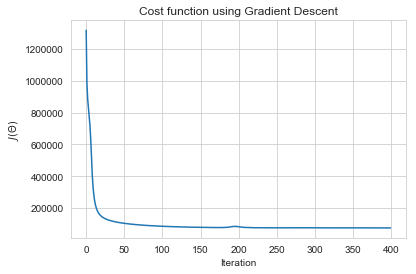

In [66]:
plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

# Part 2.8) Recommending for you

In [67]:
#We have the movie feature vector X and we have the user feature vector. Let's use those to predict ratings

new_X = paramsFinal[:num_movies*num_features].reshape(num_movies, num_features)
new_theta = paramsFinal[num_movies*num_features:].reshape(num_users, num_features)
new_predictions = np.dot(new_X, new_theta.T)

In [68]:
new_X.shape,new_theta.shape,new_predictions.shape

((1682, 10), (944, 10), (1682, 944))

In [73]:
#My predictions will be in the first column
my_predictions = new_predictions[:,0][:,np.newaxis] + Y_mean

In [85]:
import pandas as pd
df = pd.DataFrame(np.hstack((my_predictions,np.array(data_26)[:,np.newaxis])))

In [86]:
df.sort_values(by=0,ascending=False,inplace=True)

In [87]:
df.head()

,0,1
312,8.50786316161929,313 Titanic (1997)
274,8.382878749026421,275 Sense and Sensibility (1995)
317,8.317902376992048,318 Schindler's List (1993)
70,8.267578571044124,"71 Lion King, The (1994)"
142,8.266642381048577,"143 Sound of Music, The (1965)"


In [88]:
df.reset_index(drop=True, inplace=True)

In [89]:
df.head()

,0,1
0,8.50786316161929,313 Titanic (1997)
1,8.382878749026421,275 Sense and Sensibility (1995)
2,8.317902376992048,318 Schindler's List (1993)
3,8.267578571044124,"71 Lion King, The (1994)"
4,8.266642381048577,"143 Sound of Music, The (1965)"


In [92]:
print("Top 10 movie recommendations\n")
for i in range(10):
    print("Predicting rating ",round(float(df[0][i]),1)," for ",df[1][i],"\n")

Top 10 movie recommendations

Predicting rating  8.5  for  313 Titanic (1997) 

Predicting rating  8.4  for  275 Sense and Sensibility (1995) 

Predicting rating  8.3  for  318 Schindler's List (1993) 

Predicting rating  8.3  for  71 Lion King, The (1994) 

Predicting rating  8.3  for  143 Sound of Music, The (1965) 

Predicting rating  8.2  for  64 Shawshank Redemption, The (1994) 

Predicting rating  8.2  for  515 Boot, Das (1981) 

Predicting rating  8.1  for  15 Mr. Holland's Opus (1995) 

Predicting rating  8.1  for  496 It's a Wonderful Life (1946) 

Predicting rating  8.1  for  216 When Harry Met Sally... (1989) 

